<a href="https://colab.research.google.com/github/zouidine/ASA_LLMs/blob/master/AraBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zouidine/ASA_LLMs.git

Cloning into 'ASA_LLMs'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 90 (delta 20), reused 32 (delta 9), pack-reused 37
Receiving objects: 100% (90/90), 13.38 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install -r arabert/requirements.txt

Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (339/339), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=ec3c1d70e9a3b307d4d91cb084a96d42f1531fb56b001896f53b1538cf9926c1
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch

In [4]:
class Preprocessor():

    def clean_and_tokenize(self, sentences):
        clean_sentences = []
        for i in range(len(sentences)):
            text = sentences[i]
            text = tokenizer.tokenize(arabert_prep.preprocess(text))
            text.insert(0, tokenizer.cls_token)
            text.append(tokenizer.sep_token)
            clean_sentences.append(text)
        return clean_sentences

    def creat_tensor(self, sentences):
        max_len = max([len(sen) for sen in sentences])
        batch = len(sentences)
        tensor_data = torch.full((batch, max_len), 0, dtype=torch.int64)
        tensor_mask = torch.zeros(batch, max_len, dtype=torch.int64)

        for i in range(batch):
            ids = tokenizer.convert_tokens_to_ids(sentences[i])
            tensor_data[i, 0:len(ids)] = torch.tensor(ids, dtype=torch.int64)
            tensor_mask[i, 0:len(ids)] = torch.ones(1, len(ids), dtype=torch.int64)
        return tensor_data, tensor_mask

In [5]:
class rnn(nn.Module):
    def __init__(self, bert):
        super().__init__()

        self.embedding = bert
        emb_dim = bert.config.to_dict()['hidden_size']
        self.linear_out = nn.Linear(emb_dim, 1)

    def forward(self, text, mask):
        #text = [batch size, sent len]
        embedded = self.embedding(text, attention_mask=mask)[1]
        return self.linear_out(embedded).squeeze(1)

In [6]:
def get_scores(preds, y):
    acc = accuracy_score(y, preds)
    pre = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1s = f1_score(y, preds)
    return acc, pre, rec, f1s

def train(model, iterator, optimizer, criterion, epoch_no):

    epoch_loss = 0
    model.train()
    with tqdm(iterator) as it:
        for batch_no, batch in enumerate(it, start=1):
            optimizer.zero_grad()
            predictions = model(batch[0].to(device), batch[1].to(device))
            loss = criterion(predictions, batch[2].to(device))
            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss += loss.item()
            it.set_postfix(
                        ordered_dict={
                            "avg_epoch_loss": epoch_loss / batch_no,
                            "epoch": epoch_no,
                        },
                        refresh=True,
                    )

def evaluate(model, iterator):
    model.eval()
    pred = []
    targ = []
    with torch.no_grad():
        with tqdm(iterator) as it:
            for batch_no, batch in enumerate(it, start=1):
                predictions = model(batch[0].to(device), batch[1].to(device))
                pred += torch.round(torch.sigmoid(predictions)).tolist()
                targ += batch[2].tolist()

    return get_scores(pred, targ), pred, targ

In [7]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert = AutoModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
arabert_prep = ArabertPreprocessor(model_name=model_name)

# Load the data
print(60*"-")
print("Loading data:")
train_data = open("/content/ASA_LLMs/data/train_samples.tsv",
                  encoding='utf-16').read().strip().split('\n')
test_data = open("/content/ASA_LLMs/data/test_samples.tsv",
                 encoding='utf-16').read().strip().split('\n')

d_train = [x.split('\t')[0] for x in train_data]
y_train = [int(x.split('\t')[1]) for x in train_data]
d_test = [x.split('\t')[0] for x in test_data]
y_test = [int(x.split('\t')[1]) for x in test_data]

preprocess = Preprocessor()

#TRAIN
d_train = preprocess.clean_and_tokenize(list(d_train))
train_src, train_mask = preprocess.creat_tensor(d_train)
train_trg = torch.tensor(y_train, dtype=torch.float)

#TEST
d_test = preprocess.clean_and_tokenize(list(d_test))
test_src, test_mask = preprocess.creat_tensor(d_test)
test_trg = torch.tensor(y_test, dtype=torch.float)

print("Train set size:\t", len(d_train))
print("\t Positif:", sum(y_train))
print("\t Negatif:", len(d_train)-sum(y_train))

print("Test set size:\t", len(d_test))
print("\t Positif:", sum(y_test))
print("\t Negatif:", len(y_test)-sum(y_test))

#############################   LOADER   #######################################
batch_size = 32

dataset = torch.utils.data.TensorDataset(train_src, train_mask, train_trg)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=0)

dataset = torch.utils.data.TensorDataset(test_src, test_mask, test_trg)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [01:29<00:00, 2.68MiB/s]


[2024-06-20 16:23:11,881 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


------------------------------------------------------------
Loading data:
Train set size:	 10500
	 Positif: 5250
	 Negatif: 5250
Test set size:	 500
	 Positif: 250
	 Negatif: 250


In [8]:
SEED = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
model = rnn(arabert)
model = model.to(device)

optimizer = torch.optim.Adam([param for param in model.parameters() if
                              param.requires_grad == True], lr=2e-5)

criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [9]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train(model, train_loader, optimizer, criterion, epoch)

(acc, pre, rec, f1s), pred, targ = evaluate(model, test_loader)
print(f'\nAcc: {acc*100:.2f}%\nPre: {pre*100:.2f}%\nRec: {rec*100:.2f}%\nF1s: {f1s*100:.2f}%')

100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Acc: 87.00%
Pre: 90.39%
Rec: 82.80%
F1s: 86.43%


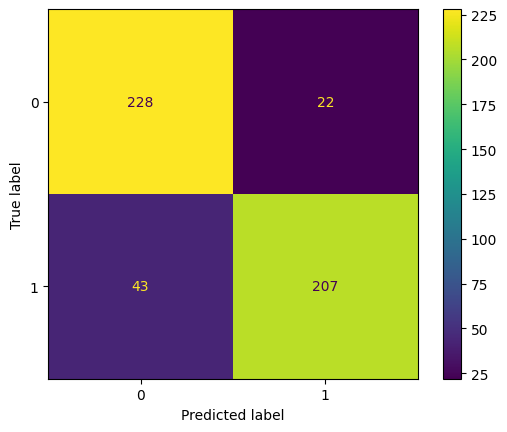

In [10]:
cm = confusion_matrix(targ, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()